<a href="https://colab.research.google.com/github/hamzakpt/Recover-Image-using-encoder-Decoder-Pytorch/blob/main/Recover_Image_using_encoder_Decoder_Pytorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip 
!unzip cats_and_dogs_filtered.zip

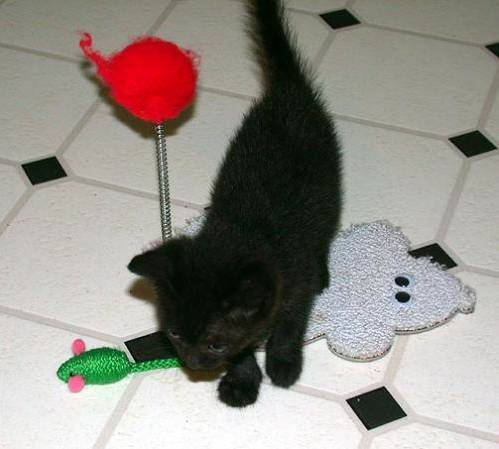

In [ ]:
from IPython.display import Image
Image(filename='cats_and_dogs_filtered/validation/cats/cat.2002.jpg') 

In [ ]:
import torch
# Device configuration
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Run on", device_name)
device = torch.device(device_name)

Run on cuda


In [ ]:

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,16,3),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        ### YOUR CODE HERE ###
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        # print("output:" , out.shape)
        out = self.layer2(out)
        # print("output2:" , out.shape)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1), # 55X55 input, output, kernal, stride, padding
                        nn.ReLU(), #output 109x109
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1), # output 111x111
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        ### YOUR CODE HERE ###
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1), #output 111x111
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1, 1),#output 111x111
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,4, 2),#output 221x221
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,55,55)
        # print("Output shape at first : ", out.shape)
        out = self.layer1(out)
        # print("After first later: ", out.shape)
        out = self.layer2(out)
        # print("output: ", out.shape)
        return out

decoder = Decoder().cuda()

In [ ]:

import random
class custom(object):
    def __call__(self,img):
        # now we have image
        index_high = random.randint(0, img.shape[1]-32)
        index_width = random.randint(0, img.shape[2]-32)
        for channel in range(3): # for all three channels
          for i in range(32): # for hight 
            for j in range(32): # for width 
              img[channel][index_high+i][index_width+j] = 1
        return img
       

In [ ]:
# load dataset 
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       custom(),
                                       transforms.ToPILImage(),
                                        transforms.Scale((224,224)),
                                       transforms.ToTensor(),
                                       ])
train_real_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.ToPILImage(),
                                        transforms.Scale((224,224)),
                                       transforms.ToTensor(),
                                       ])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      custom(),
                                      transforms.ToPILImage(),
                                       transforms.Scale((224,224)),
                                      transforms.ToTensor(),
                                      ])


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [ ]:
data_dir = "cats_and_dogs_filtered/"
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
train_real_data = datasets.ImageFolder(data_dir + '/train', transform=train_real_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
trainloader_real = torch.utils.data.DataLoader(train_real_data, batch_size=64)

testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [ ]:
# Optimizer
epoch = 100
batch_size =64
learning_rate = 0.001
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [1]:
for i in range(epoch):
    for (image,label), (image_real, _) in zip(trainloader, trainloader_real):
        image = Variable(image).cuda()
        image_real = Variable(image_real).cuda()
        if  len(image_real)==64:
          #label = Variable(label.float()).cuda()
          optimizer.zero_grad()
          output = encoder(image)
          output = decoder(output)
          loss = loss_func(output,image_real)
          loss.backward()
          optimizer.step()
        
    if i % 2 == 0:
        torch.save([encoder,decoder],'./autoencoder.pkl')
        print(loss)

In [ ]:
# now test 
for test_images, _ in testloader:
  break

In [ ]:
test_images = Variable(test_images).cuda()
output = encoder(test_images)
output = decoder(output)

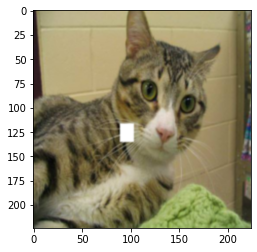

In [ ]:
index= 12
plt.imshow(transforms.ToPILImage()(test_images[index].cpu()), interpolation="bicubic")

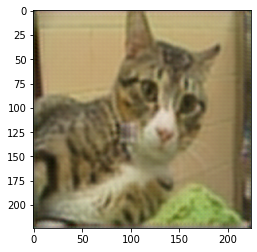

In [ ]:

plt.imshow(transforms.ToPILImage()(output[index].cpu()), interpolation="bicubic")